[GFS uses the (2 class: rain and snow) Kessler microphysics scheme](http://www.dtcenter.org/GMTB/gfs_phys_doc/group__precip.html) (in WRF: mp_physics = 1) <cite data-cite="2031184/HX6KUHZA"></cite> with simplified computation of precipitation <cite data-cite="2031184/6VR7B9X8"></cite>.

Our WRF setup uses the WRF single moment 3-class scheme (WSM3, mp_physics = 3) <cite data-cite="2031184/ETWZMQAE"></cite>.

In [1]:
import sys
sys.path.append('../python')
import numpy as np
import pandas as pd
import xarray as xr
from data import Data
from geo import cells, proj_params, cartopy_params, affine, domain_bounds, MultiPoint
from warnings import catch_warnings, simplefilter
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.figure import SubplotParams

**Note**: switching backends works.  
How to get [pdf figures](http://blog.rtwilson.com/how-to-get-nice-vector-graphics-in-your-exported-pdf-ipython-notebooks/). But works only for 'inline' backend, not interactive ('nbagg').

In [154]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

In [165]:
%matplotlib nbagg

In [39]:
import matplotlib as mpl
mpl.get_backend()

'nbAgg'

In [3]:
D = Data('../python/data.cfg')
D.open('c','station_data.h5')
D.open('d','prDaily.h5')

with xr.open_dataset('../../data/WRF/3d/geo_em.d03.nc') as d3:
    lm = d3['LANDMASK'].squeeze().load()
    clon, clat = d3['XLONG_C'].squeeze().load(), d3['XLAT_C'].squeeze().load()
    lon, lat = d3['XLONG_M'].squeeze().load(), d3['XLAT_M'].squeeze().load()
    dom3 = proj_params(d3)
    dom3_poly = domain_bounds(d3)

In [4]:
def point_select(stations, clon, clat, x, mean=True):
    i, j = cells(clon, clat, *stations[['lon', 'lat']].astype(float).values.T)
    y = x.sel_points(south_north=i, west_east=j)
    y.coords['stations'] = ('points', stations.index)
    y = y.swap_dims({'points': 'stations'})
    if mean:
        m = x.mean(['south_north', 'west_east'])
        m.expand_dims('stations')
        m['stations'] = 'mean'
        y = y.drop(list(set(y.coords) - set(m.coords)))
        return xr.concat((y, m), 'stations')
    return y

In [140]:
# CEAZA
r = D.c['pp_mm'].xs('prom', 1, 'aggr')
sta = D.sta.loc[r.columns.get_level_values('station')]
sta = sta[[dom3_poly.contains(i) for i in MultiPoint(sta[['lon', 'lat']].values)]]
r = r[sta.index]

ps = partial(point_select, sta, clon, clat)

In [136]:
# DGA
r = D.d['prDaily']
dga = r.columns.to_series().reset_index()[['nombre', 'longitud', 'latitud']]
dga.index = r.columns.get_level_values('codigo_estacion')
dga.columns = ['name', 'lon', 'lat']
dga = dga[[dom3_poly.contains(i) for i in MultiPoint(dga[['lon', 'lat']].values)]]

r = r[dga.index]
ps = partial(point_select, dga, clon, clat)

In [271]:
d5 = xr.open_dataset('../../data/WRF/3d/RAINNC_5.nc')
#d5 = xr.open_dataset('../python/RAINNC_5.nc')
x = d5['RAINNC'].isel(Time = np.arange(24, 121, 24))
x5 = xr.concat((x.isel(Time = 0), x.diff('Time')), 'Time')
a5 = d5['RAINNC'].diff('Time')

d6 = xr.open_dataset('../../data/WRF/3d/RAINNC_6.nc')
#d6 = xr.open_dataset('../python/RAINNC_6.nc')
x = d6['RAINNC'].sel(start=slice(None, '2017-07-21'))
x6 = x.isel(Time = np.arange(24, 145, 24))
x6 = xr.concat((x6.isel(Time = 0), x6.diff('Time')), 'Time')
a6 = x.diff('Time')

In [138]:
def conc(obs, mod, station_level='station', dt=0):
    """Note: if dt != 0, values are aggregated over a whole (local) day."""
    if dt==0:
        def lead(y, n):
            m = y.isel(Time=slice(n*24, (n+1)*24)).stack(t=('start', 'Time'))
            m['t'] = m.XTIME.isel(stations=0).values
            m.name = n
            return m.drop('XTIME').dropna('t')
        k = np.arange(len(mod.Time)//24)
    else:
        def lead(y, n):
            m = y.isel(Time=slice(n*24+dt, (n+1)*24+dt))
            m.name = n
            # to index to 0h at beginning of day
            m['t'] = ('start', m.XTIME.isel(Time=0).values - np.timedelta64(1, 'h'))
            return m.sum('Time').swap_dims({'start':'t'}).drop('start')
        k = np.arange((mod.Time[-1] - dt)//24)
    m = xr.concat([lead(mod, n) for n in k], pd.Index(k, name='lead'))
    o = xr.DataArray(obs, dims=['t', 'stations'][:len(obs.shape)])
    if 'stations' in o.dims:
        o['stations'] = ('stations', obs.columns.get_level_values(station_level))
    o['lead'] = 'obs'
    return xr.concat((o, m), 'lead')

In [134]:
# CEAZAMet
a5 = xr.open_dataarray('../../data/WRF/3d/RAINNC_5_diff.nc')
a6 = xr.open_dataarray('../../data/WRF/3d/RAINNC_6_diff.nc')
b5 = ps(a5)
b6 = ps(a6)

In [135]:
l5 = conc(r, b5.drop('mean', 'stations')) * 24
l6 = conc(r, b6.drop('mean', 'stations')) * 24

In [139]:
# DGA
g5 = conc(r, ps(a5, False), 'codigo_estacion', dt=4)
g6 = conc(r, ps(a6, False), 'codigo_estacion', dt=16)

In [121]:
def diff(x):
    o = x.sel(lead='obs')
    m = x.drop('obs', 'lead').dropna('t', 'all')
    return xr.concat((m - o, o), 'lead').sel(t=m.t)
def err(x, sample, order):
    f = {
        'space': lambda y: y.mean('stations'),
        'time': lambda y: y.resample(sample, 't', how='mean'),
        'diff': lambda y: diff(y),
        'abs': lambda y: np.abs(y)
    }
    for o in order:
        x = f[o](x)
    return pd.Series(x.mean('t'), index=x.lead)

def err_all(x, order=['space', 'diff', 'time', 'abs']):
    return pd.DataFrame({s: err(x, s, order) for s in ['MS', 'D', 'h']})[['MS', 'D', 'h']]

In [142]:
def bplot(h, legend=None, loc='best', cmap='Accent'):
    cm = plt.get_cmap(cmap, len(h.order) if hasattr(h, 'order') else 1)
    cols = pd.Series(index=h.x.to_index())
    i = 0
    ticks, labels = [], []
    ax = plt.gca()
    for n, c in cols.iteritems():
        obs = h.sel(x=n, lead='obs')
        b = h.sel(x=n).drop('obs', 'lead').dropna('lead', 'all').squeeze()
        a = b.lead.values.astype(int)
        j = a + i
        if hasattr(b, 'order'):
            m = b.order.values.astype(int)
            s = np.sin(m*np.pi/2) / 6
            # argsort returns the indexes of the first, second, third etc. - *NOT* the order of the element
            for k, o in list(b.argsort(0).groupby('order'))[::-1]:
                plt.bar(j + s[k], b.isel_points(order=o, lead=a), color=cm(o), width=.5)
            ax.hlines(obs.sel(order=m), j[0]-1, j[-1]+1, colors=cm(m))
            plt.legend(*zip(*[(plt.Rectangle((0, 0), 1, 1, fc=cm(k)), legend[k])
                              for k in range(len(h.order))]), loc=loc)
        else:
            plt.bar(j, b, color=cm(0))
            ax.hlines(obs, j[0]-1, j[-1]+1, colors=cm(0))
        i = j[-1] + 2
        ticks.extend(j)
        labels.extend(a+1)
        if isinstance(n, tuple):
            # use 'data' coordinates for the center-x location, but 'offset points' for the y-shift
            # https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate
            ax.annotate(n[1], (j.mean(), 0), xytext=(0,-24), textcoords='offset points', ha='center')
        cols[n] = j.mean()
    ax.tick_params(length=0, labelsize=10)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    for n, c in cols.astype(float).mean(level=0).iteritems():
        ax.annotate(n, (c, 0), xytext=(0,-36), textcoords='offset points', ha='center')

In [1113]:
order_list = [['diff', 'abs', 'space', 'time'],
              ['diff', 'abs', 'time', 'space'],
              ['diff', 'space', 'time', 'abs'],
              ['diff', 'time', 'space', 'abs'],
              ['space', 'time', 'diff', 'abs'], 
              ['time', 'space', 'diff', 'abs']]
frames = [pd.concat([err_all(l, order) for l in [l5, l6]], 1, keys=['0h', '12h']) 
          for order in order_list]
h = xr.concat([xr.DataArray(f.swaplevel(axis=1)[['MS', 'D', 'h']], dims=['lead', 'x']) for f in frames], 'order')

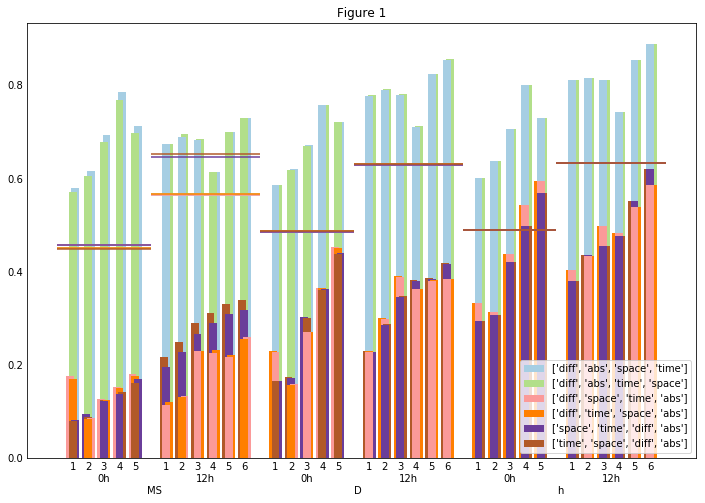

In [1137]:
fig = plt.figure(figsize=(12, 8))
bplot(h, order_list, 'lower right', 'Paired')
plt.gca().set_title('Figure 1');

The horizontal lines mark the observed values after applying the same sequence of (spatial, temporal) averaging as for the differences between simulations and observations.

**12h / MS**: Difference in mean due to lack of simulations in 2016/04-2016/06 (Fig. 2, Tab. 1): applying 'diff' means selecting only times for which both observations and simulations are available. For the monthly aggration, the weight of months with missing days is much higher in the overall average than for shorter aggragations, where the weight is spread more evenly.  
**0h / lead 1**: This appears to be due mainly to some missing simulation dates during rain events (2015/08) (Fig.3)  
**First differencing vs first averaging**: First differencing means that only (hourly) times for which both simulations and observations (for each location) enter the statistics, while first applying some (spatial, temporal) average means that the unavailability is somewhat smoothed over. The former results in more erratic statistics but somtimes lower errors.  
**Abs**: Taking the absolute value first obviously produces little differences between the various temporal aggregation scales. **It's unclear however where the pattern in lead days comes from, in particular the opposite resoponse at day 4 for 0h/12h runs.**

#### Some useful matplotlib links:
[pyplot.annotate()](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate)  
[Axes.tick_params()](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.tick_params.html#matplotlib.axes.Axes.tick_params)  
[annotation axes](https://matplotlib.org/users/annotations_guide.html)

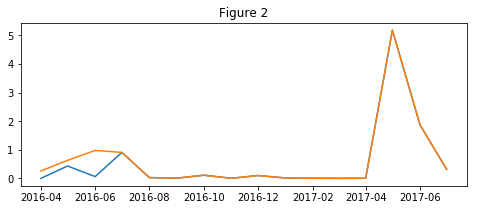

In [138]:
plt.figure(figsize=(8,3))
xt = lambda x: (x.t, x)
plt.plot(*xt(diff(l6).sel(lead='obs').resample('MS','t', how='mean').mean('stations')), label='diff first')
plt.plot(*xt(diff(l6.resample('MS','t', how='mean').mean('stations')).sel(lead='obs')), label='mean first')
plt.gca().set_title('Figure 2');

In [782]:
pd.DataFrame([
    h.sel(order=3, lead='obs', x=('MS','12h')), 
    err_all(l6.sel(t=slice('2016-08', None)), ['diff', 'sample', 'space', 'abs', 'mean']).loc['obs', 'MS']],
    index=['original', 'first months removed'], columns=['mean of monthly means']).T

original  first months removed
mean of monthly means  0.652631              0.638331

In [140]:
x = xr.open_dataarray('../../data/WRF/3d/RAINNC_5.nc').isel(Time = np.arange(24, 121, 24)).mean(['south_north', 'west_east'])
x5 = xr.concat((x.isel(Time = 0), x.diff('Time')), 'Time')

In [626]:
x = xr.open_dataarray('../../data/WRF/3d/RAINNC_6.nc').isel(Time = np.arange(24, 145, 24)).mean(['south_north', 'west_east'])
x6 = xr.concat((x.isel(Time = 0), x.diff('Time')), 'Time')

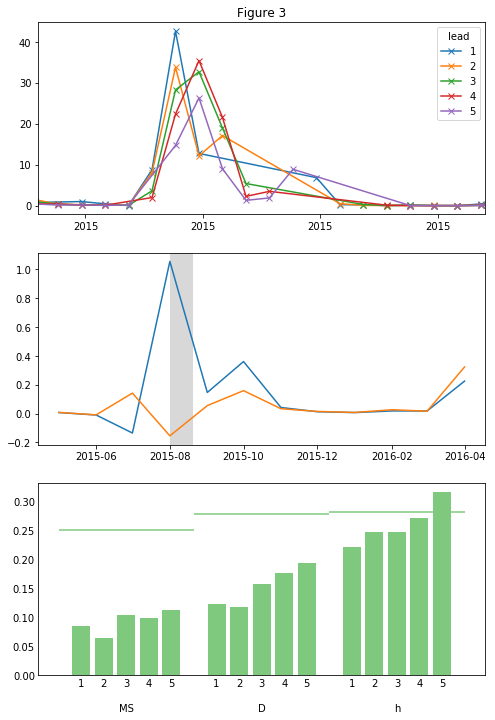

In [143]:
fig, axs = plt.subplots(3, 1, figsize=(8,12))
axs[0].set_title('Figure 3')
# detail plot of daily mean model data
plt.sca(axs[0])
for i in np.arange(5):
    plt.plot(x5.XTIME[:, i], x5[:, i], 'x-', label=i+1)
axs[0].set_xlim('2015-08-01', '2015-08-20')
axs[0].set_xticks(np.arange(*axs[0].get_xlim())[2::5])
plt.legend(title='lead')

# monthly means
plt.sca(axs[1])
xt = lambda x: (x.t, x)
plt.plot(*xt(diff(l5).sel(lead='0').resample('MS','t', how='mean').mean('stations')), label='diff first')
plt.plot(*xt(diff(l5.resample('MS','t', how='mean').mean('stations')).sel(lead='0')), label='mean first')
axs[1].axvspan(*axs[0].get_xlim(), fc='gray', alpha=.3)

# remove the respective time interval from the statistics and replot bars
h1 = err_all(xr.concat((l5.sel(t=slice(None, '2015-08-01')), 
                       l5.sel(t=slice('2015-08-20', None))), 't'), ['diff', 'time', 'space', 'abs'])
plt.sca(axs[2])
bplot(xr.DataArray(h1[['MS', 'D', 'h']], dims=['lead', 'x']));

In [798]:
order_list2 = [['diff', 'space', 'time', 'abs'],
              ['diff', 'time', 'space', 'abs'],
              ['space', 'diff', 'time', 'abs'],
              ['time', 'diff', 'space', 'abs'],
              ['space', 'diff', 'abs', 'time'],
              ['time', 'diff', 'abs', 'space'],
              ['space', 'time', 'diff', 'abs'], 
              ['time', 'space', 'diff', 'abs']]
frames = [pd.concat([err_all(l, order) for l in [l5, l6]], 1, keys=['0h', '12h']) 
          for order in order_list2]
h2 = xr.concat([xr.DataArray(f.swaplevel(axis=1)[['MS', 'D', 'h']], dims=['lead', 'x']) for f in frames], 'order')

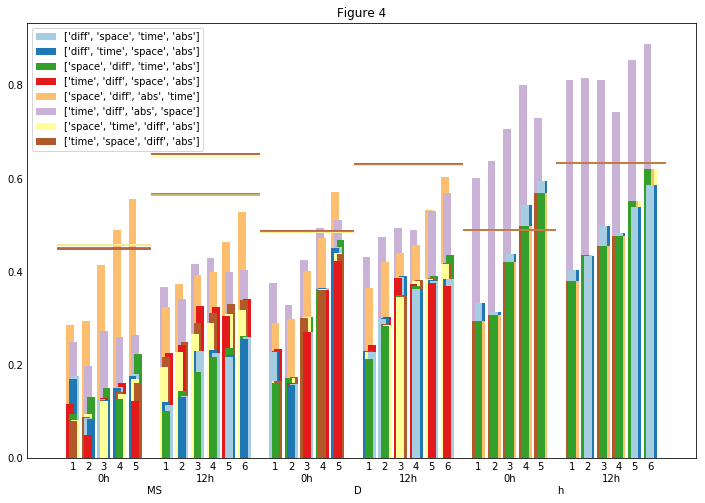

In [1140]:
fig = plt.figure(figsize=(12, 8))
bplot(h2, order_list2, 'upper left', 'Paired')
plt.gca().set_title('Figure 4');

**h**: Time-averaging makes no difference here (already hourly), but space-averaging before taking the difference.   
**diff before vs after time**: Time-averaging before differencing might lead to larger errors.   
**space after diff**: Not a huge difference   
**space after abs**: Obviously this contains spatial errors.

**Conclusion**: For aggregates, use *space, diff, time, abs*. My original was *time, space, diff, abs*, which does not account for the concurrency of (observation, simulation) pairs.

In [846]:
from scipy import interpolate as ip
from pyproj import Proj

def interp2Dn(lon, lat, x, sta, coords=['XTIME']):
    p = Proj(**dom3)
    g = affine(*p(lon.values, lat.values))
    xy = (np.arange(lon.shape[0]), np.arange(lon.shape[1]))
    order = x.dims.index('south_north') < x.dims.index('west_east')
    i, j = p(*sta[['lon', 'lat']].astype(float).values.T)
    co = np.roll(g(np.r_['0,2', [i, j]]).T, int(order), 1)
    d = list(set(x.dims) - {'south_north', 'west_east'})
    y = xr.concat([
        xr.concat([
            xr.DataArray(
                ip.interpn(xy, x.loc[{d[0]:a, d[1]:b}].values, co, 'linear'),
                coords=[('stations', sta.index)]
            ) for b in x[d[1]]], 
            pd.Index(x[d[1]], name = d[1])
        ) for a in x[d[0]]],
        pd.Index(x[d[0]], name = d[0])
    )
    for c in coords:
        y[c] = x[c]
    return y

In [847]:
# WRF linearly interpolated to station locations
i5 = conc(r, interp2Dn(lon, lat, a5, sta))*24
i6 = conc(r, interp2Dn(lon, lat, a6, sta))*24

In [1122]:
frames = [
    pd.concat([err_all(l) for l in [l5, l6]], 1, keys=['0h', '12h']),
    pd.concat([err_all(conc(r.mean(1), b.sel(stations='mean'))*24, ['diff', 'time','abs']) 
                     for l in [b5, b6]], 1, keys=['0h', '12h']),
    pd.concat([err_all(l) for l in [i5, i6]], 1, keys=['0h', '12h']),
    pd.concat([pd.DataFrame({s: err(l, s, ['space', 'diff', 'time', 'abs']) for s in ['MS', 'D']}) 
               for l in [g5, g6]], 1, keys=['0h', '12h'])
]
frames[-1][('0h','h')] = np.nan
frames[-1][('12h','h')] = np.nan
h3 = xr.concat([xr.DataArray(f.swaplevel(axis=1)[['MS', 'D', 'h']], dims=['lead', 'x']) for f in frames], 'order')

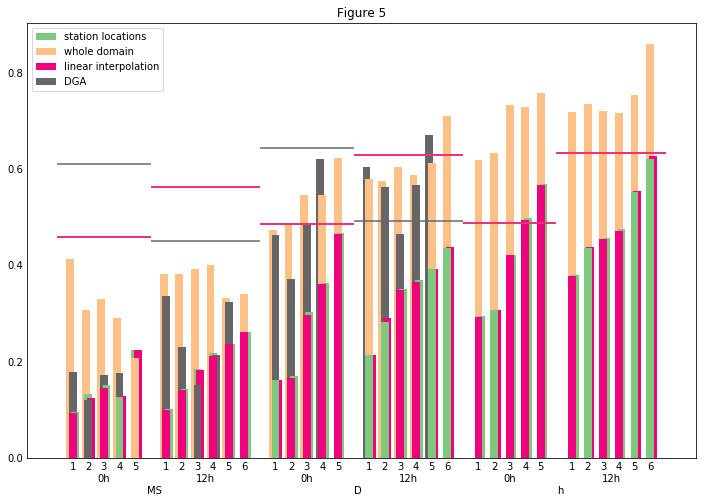

In [1141]:
fig = plt.figure(figsize=(12, 8))
bplot(h3, ['station locations', 'whole domain', 'linear interpolation', 'DGA'])
plt.gca().set_title('Figure 5');

Now, *space, diff, time, abs* is used, i.e. spatial averaging before computing the error, then temporal aggregation. Linear interpolation changes little w.r.t. nearest neighbor. **DGA** only has daily data, so the "lead" days are somewhat inaccurate, since the model data is shifted to fit local days (however, the UTC-4 time zone is used, which **might not be what DGA uses!**).  
Interestingly, the averages of the DGA stations over the two time periods change in opposite directions for DGA and CEAZAMet stations between the two time periods.

Clearly, using the whole domain average of precipitation vs. only the cells where stations are located gives a worse fit.

In [146]:
sys.path.append('../miniconda3/envs/iris/lib/python3.6/site-packages/')
import iris
import iris.plot as iplt
import iris.coord_categorisation as ccat
from datetime import datetime, timedelta
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True

In [147]:
def adco(cube):
    ccat.add_day_of_year(cube, 'time', 'day')
    ccat.add_year(cube, 'time', 'year')
    ccat.add_hour(cube, 'time', 'hour')
    return cube
def xtr(cube, h):
    x = cube.copy().extract(iris.Constraint(hour = h))
    x.remove_coord('hour')
    return x
def split(x, a):
    crt = (lambda t: t > datetime(2016, 4, 24)) if a else (lambda t: t < datetime(2016, 4, 25))
    return x.extract(iris.Constraint(time = crt))
def mean(x):
    with catch_warnings():
        simplefilter('ignore')
        return x.collapsed('time', iris.analysis.MEAN)
def delay(cube, dt):
    x = cube.copy()
    t = x.coord(axis='t')
    d = x.coord_dims(t.name())[0]
    n = t.units.num2date(t.points) + dt
    x.remove_coord(t.name())
    x.add_dim_coord(
        iris.coords.DimCoord(t.units.date2num(n), 
                             units=t.units, 
                             **{s: getattr(t, s) for s in ['standard_name', 'long_name', 'var_name']}), d)
    return x

In [148]:
def pint(x, datetime='D'):
    i = np.arange(len(sta))
    tc = x.coord(axis='t')
    t = tc.units.num2date(tc.points).astype('datetime64[{}]'.format(datetime))
    y = x.interpolate([('longitude', sta['lon']), ('latitude', sta['lat'])], 
                      iris.analysis.Linear(extrapolation_mode='mask'))
    return xr.DataArray(y.data[:, i, i], coords=[('t', t), ('stations', sta.index)])

In [149]:
with catch_warnings():
    simplefilter('ignore')
    c6 = adco(iris.load('../../data/fnl/ppt/gdas1.fnl0p25.f06.nc', 'Total precipitation')[0])
    c9 = adco(iris.load('../../data/fnl/ppt/gdas1.fnl0p25.f09.nc', 'Total precipitation')[0])
    c0 = (xtr(c6, 0) + xtr(c9, 0))
    c1 = (xtr(c6, 12) + xtr(c9, 12))
c = c0 + delay(c1, timedelta(hours=-12)) # shift the f09 files back to 0h initial time so iris will add them

In [141]:
def hsums(r, n, dt='3h'):
    x = r.copy()
    # if I only shift by three hours, the groupby action will appropriately apportion the 0:00h time to the previous day 
    # (since it represents the accumulation between 23:00h and 0:00h).
    x.index += pd.Timedelta(dt)
    s = x.groupby((x.index.date, x.index.hour // n)).sum()
    # this indexes to 'initial' hour
    t = [np.datetime64(d) + np.timedelta64(n * h, 'h') for d, h in s.index]
    return xr.DataArray(s, coords=[('t', t), ('stations', s.columns.get_level_values('station'))])

In [150]:
# GFS
s = hsums(r, 6)
ls = xr.concat((s, pint(c6, 'h')), pd.Index(['CEAZAMet', 'GFS'], name='source'))

**NOTE IMPORTANT**: 
xarray 0.9.6 has a bug and doesn't allow '.date' accessor for datetime-groupby   
also, DataArrray.resample(how = '**sum**') returns **0** instead of **NaN** if all elements in a sample period are NaNs (how = '**mean**' is unaffected)

In [151]:
# ERA
era = adco(iris.load('../../data/analyses/ERA-ppt.nc', iris.Constraint(time=lambda t: t > datetime(2004,1,30)))[0])
eri = pint(era, 'h') * 1000
e = eri.copy()
e['t'] = e.t - pd.Timedelta('12h') # ERA dataset has validity times, not initial times
le = xr.concat((hsums(r, 12), e), pd.Index(['CEAZAMet', 'ERA'], name='source'))

In [36]:
def ab(a, b, lead=0):
    return b.sel(t=slice(str(a6.start.values[0]), None)).combine_first(
        a.sel(t=slice(str(a5.start.values[0]), None))
    ).sel(lead=['obs',lead]).mean('stations').resample('D', 't', how='mean')

def lplot(c, iterate='source', legend=None):
    with catch_warnings():
        simplefilter('ignore')
        d = c.where(c>0.1)
    for i, s in enumerate(c[iterate].values):
        p = plt.plot(c.t, c.sel(**{iterate: s}), label=legend[i] if legend is not None else s)[0]
        plt.plot(d.t, d.sel(**{iterate: s}), marker='x', ls='none', color=p.get_color())
    plt.legend()

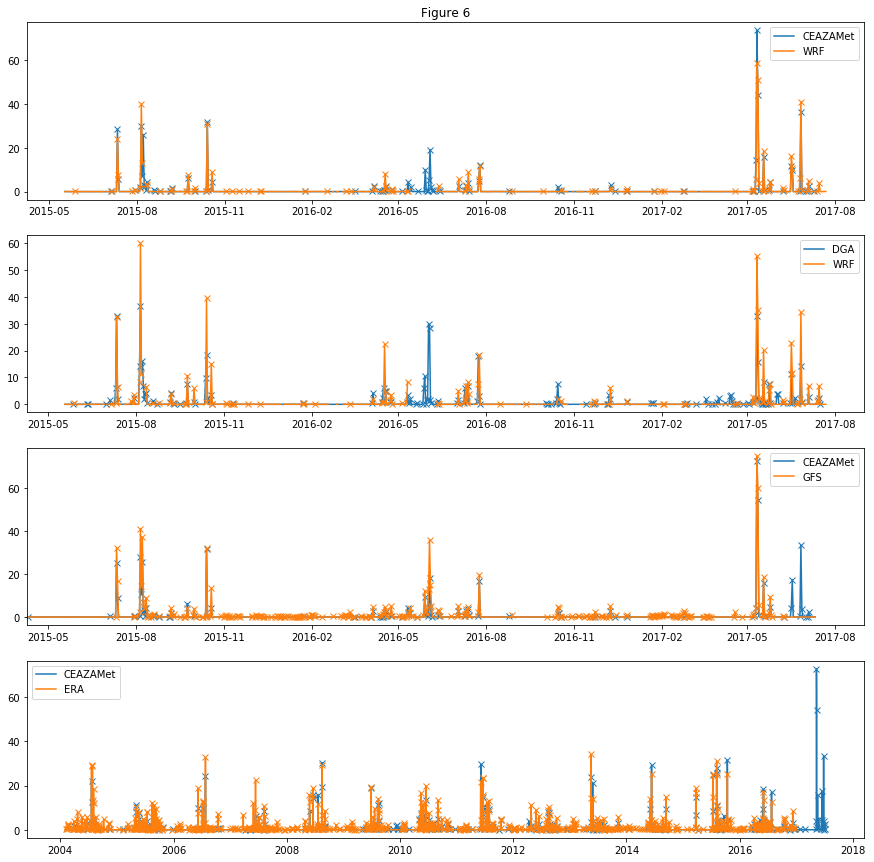

In [173]:
fig, axs = plt.subplots(4, 1, figsize=(15,15))
plt.sca(axs[0])
lplot(ab(l5, l6), 'lead', ['CEAZAMet', 'WRF'])
plt.sca(axs[1])
lplot(ab(g5, g6), 'lead', ['DGA', 'WRF'])
plt.sca(axs[2])
lplot(ls.mean('stations').resample('D', 't', how='sum')) # Note: 'sum' seems to have a bug
plt.sca(axs[3])
lplot(le.mean('stations').sel(t=slice('2004-01-31', None)).resample('D', 't', how='sum'))
axs[0].set_title('Figure 6')
axs[2].set_xlim(axs[1].get_xlim());

/home/arno/Documents/code/conda/envs/iris/lib/python3.6/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/arno/Documents/code/conda/envs/iris/lib/python3.6/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


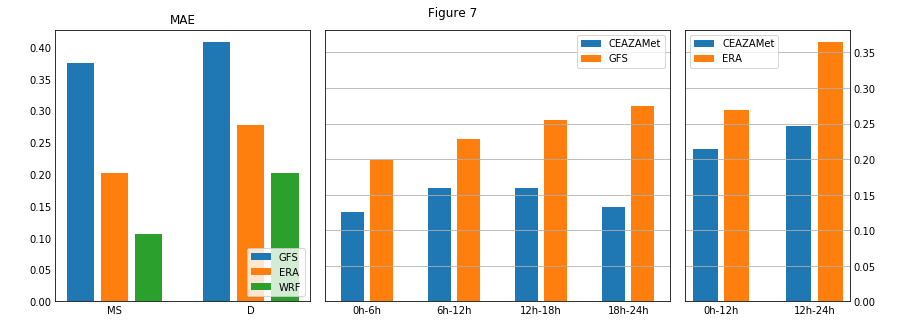

In [155]:
# This was at the time of download the earliest availability for GFS/FNL 0.25 deg dataa
ts = lambda x:x.sel(t=slice('2015-07-08', None))
tt = lambda x: ts(x).sel(lead=['obs', '0'])

a = ts(ls).mean('stations').dropna('t', 'any').groupby('source').apply(lambda x:x.groupby('t.hour').mean())
b = ts(le).mean('stations').dropna('t', 'any').groupby('source').apply(lambda x:x.groupby('t.hour').mean())

# Don't use resample 'sum', it replaces NaNs with 0
c = [ts(x).mean('stations').diff('source') for x in [ls * 4, le * 2]]
c.append(tt(l6).combine_first(tt(l5)).mean('stations').diff('lead'))
c = [[np.abs(x.resample(f, 't', how='mean')).mean('t').values for f in ['MS', 'D']] for x in c]

d = 3
axs = []
fig = plt.figure(figsize=(12,5), subplotpars=SubplotParams(left=.04, right=.96))

axs.append(plt.subplot2grid((1, 9), (0, 0), 1, 3))
for i, s in enumerate(zip(np.array(c).squeeze(), ['GFS', 'ERA', 'WRF'])):
    plt.bar(np.arange(2) * 4 + i, s[0], label = s[1])
plt.legend(loc = 'lower right')
axs[-1].set_xticks(np.arange(2)*4 + 1)
axs[-1].set_xticklabels(['MS', 'D'])
axs[-1].tick_params(length=0)
axs[-1].set_title('MAE')

axs.append(plt.subplot2grid((1, 9), (0, 3), 1, 4))
for i, s in enumerate(a.source.values):
    plt.bar(np.arange(4)*d + i, a.sel(source=s), label=s)
plt.legend()
axs[-1].set_xticks(np.arange(4)*d + .5)
axs[-1].set_xticklabels(['0h-6h', '6h-12h', '12h-18h', '18h-24h'])
axs[-1].tick_params(length=0)
axs[-1].set_yticklabels([])
axs[-1].grid(axis='y')

axs.append(plt.subplot2grid((1, 9), (0, 7), 1, 2))
for i, s in enumerate(b.source.values):
    plt.bar(np.arange(2)*d + i, b.sel(source=s), label=s)
plt.legend();
axs[1].set_ylim(*axs[2].get_ylim())
axs[-1].set_xticks(np.arange(2)*d + .5)
axs[-1].set_xticklabels(['0h-12h', '12h-24h'])
axs[-1].tick_params(length=0);
axs[-1].yaxis.set_ticks_position('right')
axs[-1].grid(axis='y')

ax = fig.add_axes((0, .9, 1, 0))
ax.axis('off')
ax.set_title('Figure 7');

In [405]:
from cartopy import crs
from cartopy.io import shapereader
import matplotlib.gridspec as gs

In [406]:
proj = crs.LambertConformal(**cartopy_params(dom3))

In [407]:
coast = shapereader.Reader('../../data/geo/GSHHG/coast.shp')
border = shapereader.Reader('../../data/geo/GSHHG/border.shp')
rivers = shapereader.Reader('../../data/geo/GSHHG/river.shp')

In [409]:
def gridw(rows, cols, width=1, pad=[]):
    l, r, t, b = [int(p in pad) for p in ['left', 'right', 'top', 'bottom']]
    g = gs.GridSpec(rows + t + b, cols * width + l + r)
    for i in range(rows):
        for j in range(cols):
            yield g[i + t, j * width + l: (j + 1) * width + l]
    yield g

In [410]:
def mplot(sta, grid, x, count=None, vmin=None, vmax=None, cbar=True, title=None, scale=100):
    ax = plt.subplot(grid, projection=proj)
    ax.background_patch.set_color('lightblue')
    ax.add_geometries(coast.geometries(), crs=proj, facecolor='lightgray', edgecolor='k', zorder=0)
    ax.add_geometries(rivers.geometries(), crs=proj, facecolor='none', edgecolor='b', zorder=0)
    ax.add_geometries(border.geometries(), crs=proj, facecolor='none', edgecolor='g', linewidth=.5, zorder=0)
    ax.set_extent((-72.2, -69.8, -32.5, -28.2), crs=proj)
    
    i, j = sta[['lon', 'lat']].astype(float).values.T
    if count is not None:
        count = (count / count.max() * scale).values
    p = ax.scatter(i, j, c=x.values, s=count, vmin=vmin, vmax=vmax)
    if title is not None:
        ax.set_title(title)
    if cbar:
        plt.colorbar(p, ax=ax)
    return p

In [394]:
def mae(x):
    return bias(np.abs(x))
def bias(x):
    return (x.mean('t'), x.count('t'))

In [230]:
p5, p6 = [diff(l).isel(lead=0) for l in [l5, l6]]
a, b = [p.resample('MS', 't', how='mean') for p in [p5, p6]]
c, d = [p.resample('D', 't', how='mean') for p in [p5, p6]]
r1 = r['2015-05-18':'2016-04-24']
r2 = r['2016-04-25':]

/usr/local/lib/python3.6/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/usr/local/lib/python3.6/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


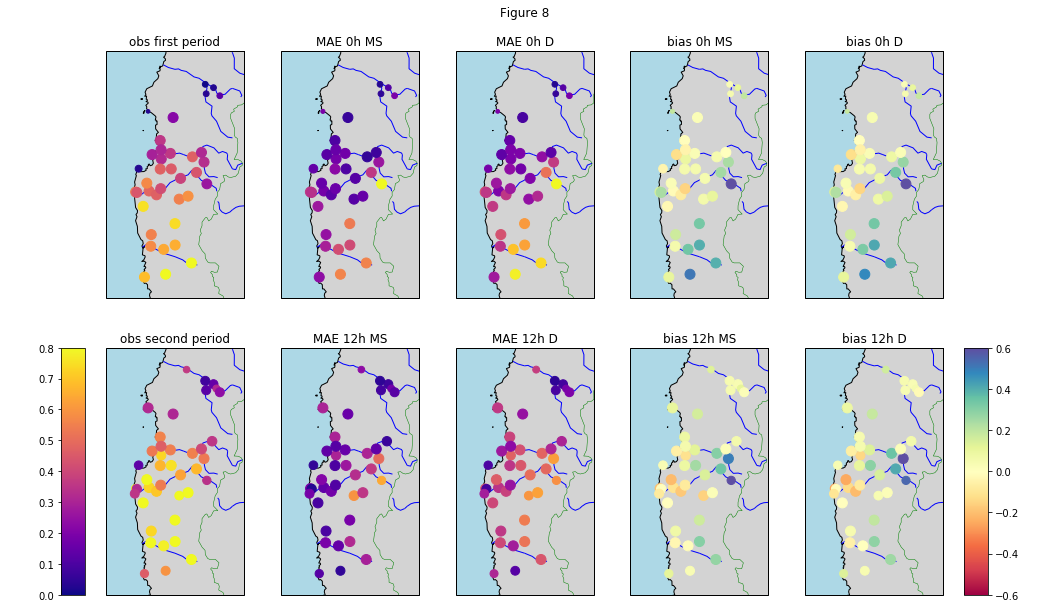

In [231]:
fig = plt.figure(figsize=(14, 10), subplotpars=SubplotParams(left=.04, right=.96))

g = gridw(2, 5, 6, ['left', 'right'])

ma = .8
mb = .6
plt.set_cmap('plasma')
mplot(sta, next(g), r1.mean()*24, r1.count(), 0, ma, False, 'obs first period')
mplot(sta, next(g), *mae(a), 0, ma, False, 'MAE 0h MS')
mplot(sta, next(g), *mae(c), 0, ma, False, 'MAE 0h D')
plt.set_cmap('Spectral')
mplot(sta, next(g), *bias(a), -mb, mb, False, 'bias 0h MS')
mplot(sta, next(g), *bias(c), -mb, mb, False, 'bias 0h D')
plt.set_cmap('plasma')
mplot(sta, next(g), r2.mean()*24, r2.count(), 0, ma, False, 'obs second period')
p1 = mplot(sta, next(g), *mae(b), 0, ma, False, 'MAE 12h MS')
p1 = mplot(sta, next(g), *mae(d), 0, ma, False, 'MAE 12h D')
plt.set_cmap('Spectral')
p2 = mplot(sta, next(g), *bias(b), -mb, mb, False, 'bias 12h MS')
p2 = mplot(sta, next(g), *bias(d), -mb, mb, False, 'bias 12h D')

gr = next(g)
cb = plt.colorbar(p1, cax=plt.subplot(gr[1, 0]))
cb.ax.yaxis.set_ticks_position('left')
plt.colorbar(p2, cax=plt.subplot(gr[1, -1]))

ax = fig.add_axes((0, .92, 1, 0))
ax.axis('off')
ax.set_title('Figure 8');

In [227]:
f5, f6 = [diff(g).isel(lead=0) for g in [g5, g6]]
a, b = [f.resample('MS', 't', how='mean') for f in [f5, f6]]
c, d = [f.resample('D', 't', how='mean') for f in [f5, f6]]

/usr/local/lib/python3.6/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/usr/local/lib/python3.6/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


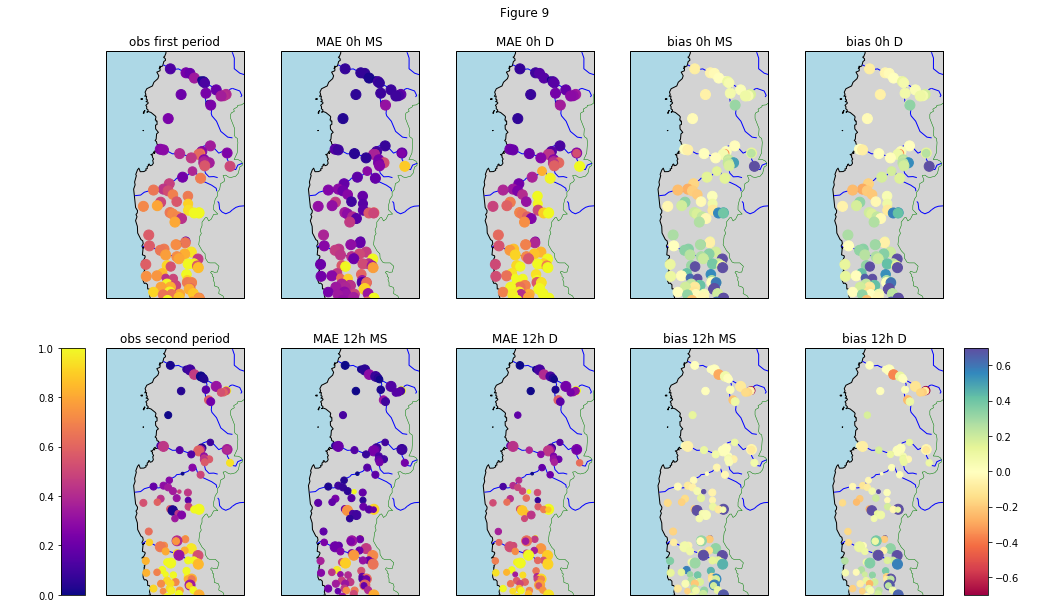

In [228]:
fig = plt.figure(figsize=(14, 10), subplotpars=SubplotParams(left=.04, right=.96))

g = gridw(2, 5, 6, ['left', 'right'])

ma = 1
mb = .7
plt.set_cmap('plasma')
mplot(dga, next(g), r1.mean(), r1.count(), 0, ma, False, 'obs first period')
mplot(dga, next(g), *mae(a), 0, ma, False, 'MAE 0h MS')
mplot(dga, next(g), *mae(c), 0, ma, False, 'MAE 0h D')
plt.set_cmap('Spectral')
mplot(dga, next(g), *bias(a), -mb, mb, False, 'bias 0h MS')
mplot(dga, next(g), *bias(c), -mb, mb, False, 'bias 0h D')
plt.set_cmap('plasma')
mplot(dga, next(g), r2.mean(), r2.count(), 0, ma, False, 'obs second period')
p1 = mplot(dga, next(g), *mae(b), 0, ma, False, 'MAE 12h MS')
p1 = mplot(dga, next(g), *mae(d), 0, ma, False, 'MAE 12h D')
plt.set_cmap('Spectral')
p2 = mplot(dga, next(g), *bias(b), -mb, mb, False, 'bias 12h MS')
p2 = mplot(dga, next(g), *bias(d), -mb, mb, False, 'bias 12h D')

gr = next(g)
cb = plt.colorbar(p1, cax=plt.subplot(gr[1, 0]))
cb.ax.yaxis.set_ticks_position('left')
plt.colorbar(p2, cax=plt.subplot(gr[1, -1]))

ax = fig.add_axes((0, .92, 1, 0))
ax.axis('off')
ax.set_title('Figure 9');

/usr/local/lib/python3.6/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/usr/local/lib/python3.6/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


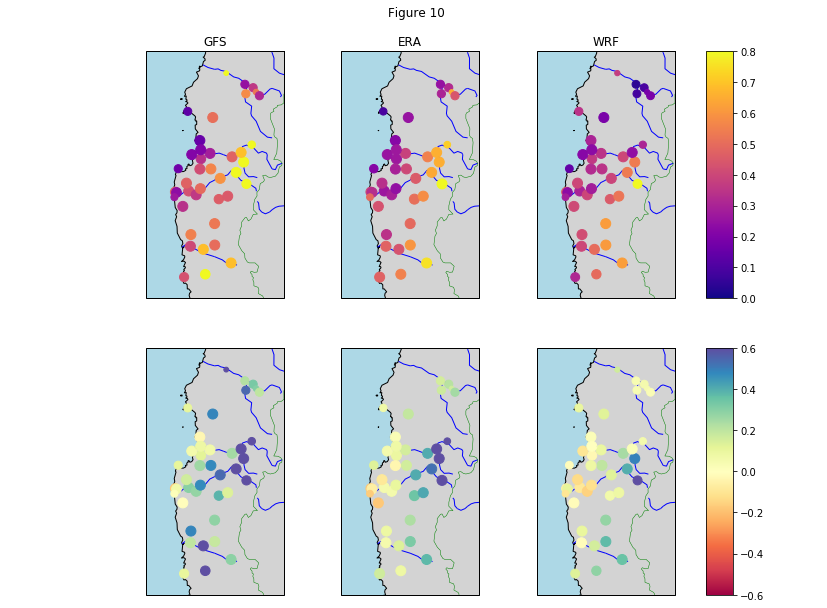

In [262]:
tu = lambda x: ts(x).diff('source').resample('D', 't', how='mean')

a = tt(l6).combine_first(tt(l5)).diff('lead')

fig = plt.figure(figsize=(11, 10))
g = gridw(2, 3, 6, ['right'])

ma = .8
plt.set_cmap('plasma')
mplot(sta, next(g), *mae(tu(ls * 4)), 0, ma, False, 'GFS')
mplot(sta, next(g), *mae(tu(le * 2)), 0, ma, False, 'ERA')
p1 = mplot(sta, next(g), *mae(tu(a)), 0, ma, False, 'WRF')

mb = .6
plt.set_cmap('Spectral')
mplot(sta, next(g), *bias(tu(ls * 4)), -mb, mb, False)
mplot(sta, next(g), *bias(tu(le * 2)), -mb, mb, False)
ps = mplot(sta, next(g), *bias(tu(a)), -mb, mb, False)

gr = next(g)
plt.colorbar(p1, cax=plt.subplot(gr[0, -1]))
plt.colorbar(p2, cax=plt.subplot(gr[1, -1]))

ax = fig.add_axes((0, .92, 1, 0))
ax.axis('off')
ax.set_title('Figure 10');

In [163]:
a = ts(l6).combine_first(ts(l5)).mean('stations')

<IPython.core.display.Javascript object>


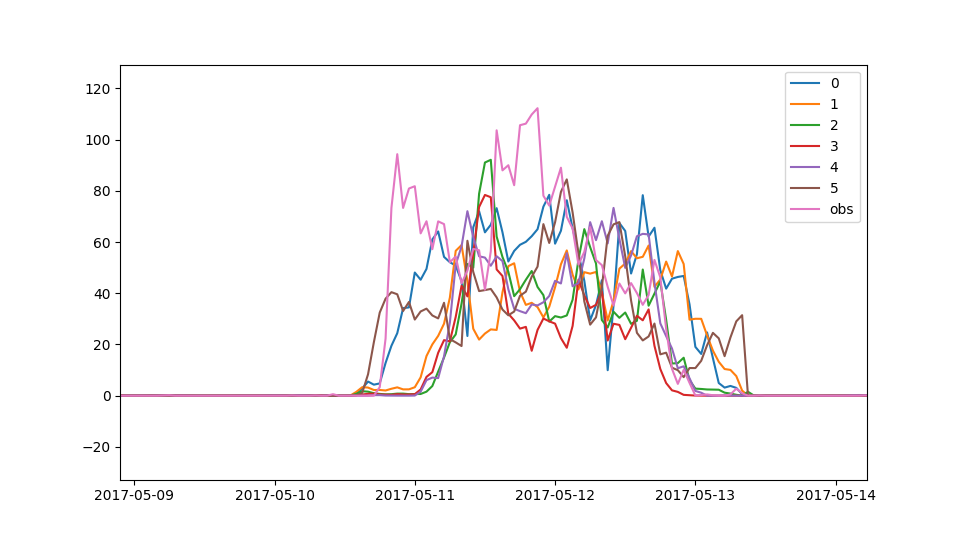

In [168]:
plt.figure()
for s in a.lead.values:
    b = a.sel(lead=s)
    plt.plot(b.t, b, label=s)
plt.legend()

In [181]:
b = b6.sel(stations='mean', start=slice('2017-05-05', '2017-05-10'))

<IPython.core.display.Javascript object>


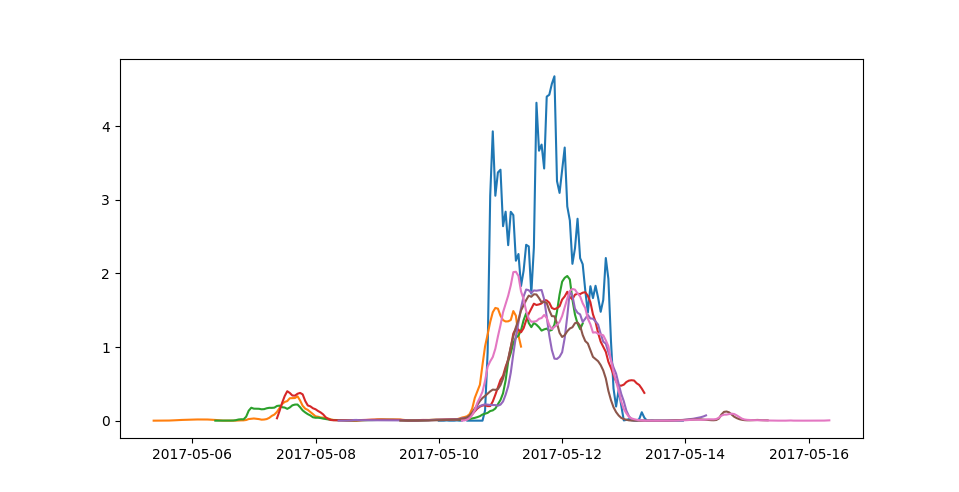

In [186]:
plt.figure()
plt.plot(r['2017-05-10':'2017-05-13'].mean(1))
for s in b.start:
    c = b.sel(start=s)
    plt.plot(c.XTIME, c)

In [303]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [424]:
def event(v, b, start=None):
    t = np.array(v.index, dtype='datetime64')
    o = v.dropna(1, 'all')
    m = b.sel(stations=o.columns.get_level_values('station'))
    plt.plot(o.mean(1), linewidth=3)
    o = xr.DataArray(o, coords=[('t', o.index), ('stations', o.columns.get_level_values('station'))])
    if start is None:
        start = np.unique(np.where((b.XTIME >= t.min()) & (b.XTIME <= t.max()))[2])
    def plot(i, s):
        c = m.isel(start=s)
        ct = c.XTIME.isel(stations=0).values
        c['t'] = ('Time', ct)
        p = plt.plot(ct, c.mean('stations'), label=s)[0]
        x1 = mdates.date2num(pd.to_datetime(ct.min()))
        x2 = mdates.date2num(pd.to_datetime(ct.max()))
        re = Rectangle((x1, -(i % (len(b6.Time) / 24)) *.25 - .25), x2-x1, .2, 
                       color=p.get_color(), alpha=.4)
        plt.gca().add_patch(re)
        return xr.concat((o, c.swap_dims({'Time': 't'}).drop(['XTIME', 'start', 'Time'])), 'source')
    n = [plot(i, s) for i, s in enumerate(start)]
    plt.gca().set_xlim((t.min(), t.max()))
    plt.legend()
    return n

<IPython.core.display.Javascript object>


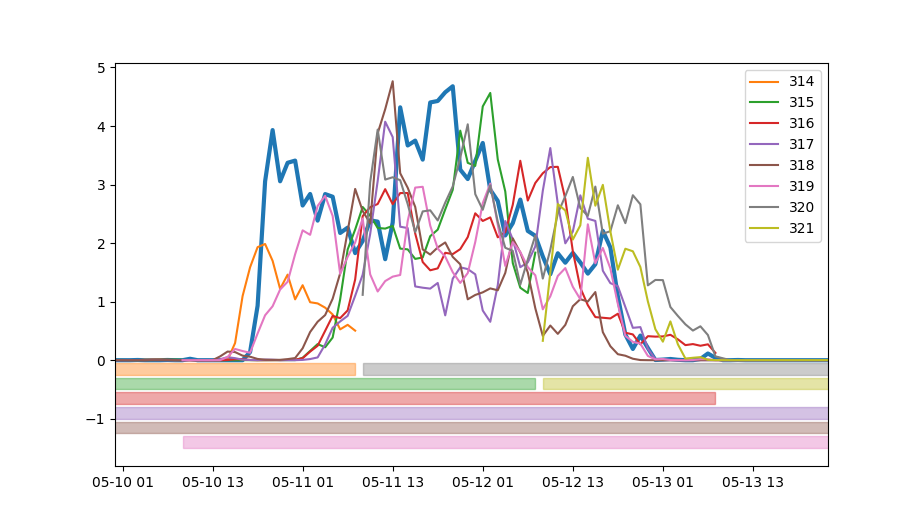

In [425]:
plt.figure()
m = event(r['2017-05-10':'2017-05-13'], b6, range(314, 322))

In [449]:
def gridh(rows, cols, width=1, pad=[]):
    l, r, t, b = [int(p in pad) for p in ['left', 'right', 'top', 'bottom']]
    g = gs.GridSpec(rows + t + b, cols * width + l + r)
    for j in range(cols):
        for i in range(rows):
            yield g[i + t, j * width + l: (j + 1) * width + l]
    yield g

<IPython.core.display.Javascript object>


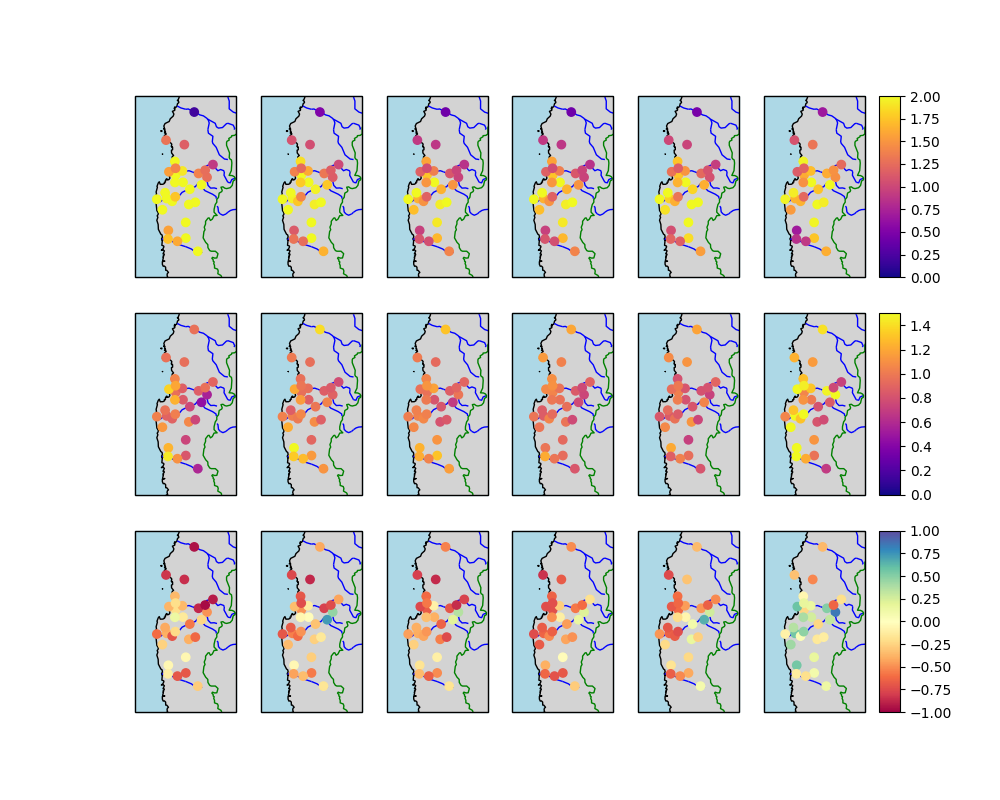

In [454]:
plt.figure(figsize=(10,8))
g = gridh(3, 6, 5, ['right'])
ma = 2
mb = 1.5
mc = 1
for n in m[1:-1]:
    d = n.diff('source').squeeze()
    o = n.isel(source=0).where(d.notnull()).mean('t')
    plt.set_cmap('plasma')
    p1 = mplot(sta.loc[n.stations], next(g), o, vmin=0, vmax=ma, cbar=False)
    p2 = mplot(sta.loc[n.stations], next(g), mae(d)[0] / o, vmin=0, vmax=mb, cbar=False)
    plt.set_cmap('Spectral')
    p3 = mplot(sta.loc[n.stations], next(g), bias(d)[0] / o,vmin=-mc, vmax=mc, cbar=False)

gr = next(g)
plt.colorbar(p1, cax=plt.subplot(gr[0, -1]))
plt.colorbar(p2, cax=plt.subplot(gr[1, -1]))
plt.colorbar(p3, cax=plt.subplot(gr[2, -1]))

In [441]:
gr

In [432]:
d = n.diff('source').squeeze()

In [434]:
n.isel(source=0)

<xarray.DataArray (t: 183, stations: 30)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * t         (t) datetime64[ns] 2017-05-06T09:00:00 2017-05-06T10:00:00 ...
  * stations  (stations) object '3' '4' '5' '6' '8' '9' 'ANDA' 'CAN' 'CHHT' ...

In [439]:
n.isel(source=0).where(d.notnull()).mean('t')

<xarray.DataArray (stations: 30)>
array([ 2.876744,  1.559649,  2.229825,  1.385965,  1.270175,  1.915789,
        2.986842,  1.568421,  2.719298,  2.296491,  2.526316,  2.985965,
        2.421053,  0.198246,  2.457895,  2.140351,  1.614035,  2.212281,
        0.910526,  1.401754,  2.135088,  1.301754,  1.736842,  1.159649,
        2.422807,  2.364912,  1.261053,  2.789474,  3.283684,  1.754386])
Coordinates:
  * stations  (stations) object '3' '4' '5' '6' '8' '9' 'ANDA' 'CAN' 'CHHT' ...